![img](https://drive.google.com/uc?export=view&id=1kgX98Ziw9LzgBCT2BxChttfrTcBltLej)




##### **MÓDULO 4: APLICACIONES INFORMÁTICAS**

##### **Integrantes:**

- Carolina Castelvetri
- Consuelo Nuñez
- Jorge Sarrouf
- Lucas Gette
- Martin Boccardo


----

## **Objetivo**

A partir de la información obtenida de la base de datos **Central de Deudores del BCRA**, nos proponemos analizar si existe diferencias entre el nivel de morosidad entre empresas y personas, distinguiendo a las personas por género (definiendo como mora cuando la situación de la deuda es 3 o más).

## Dataset

Para la realización de este trabajo vamos a utilizar un conjunto de datos que componen la Central de Deudores del  Sistema  Financiero, provista por el [BCRA](http://www.bcra.gob.ar/BCRAyVos/Situacion_Crediticia.asp).

Los datos corresponden a información consolidada por clave de identificación fiscal (CUIT, CUIL o CDI) respecto de financiaciones otorgadas por entidades financieras, fideicomisos financieros, entidades no financieras emisoras de tarjetas de crédito / compra, otros proveedores no financieros de créditos, sociedades de garantía recíproca y fondos de garantía de carácter público y, además, cheques rechazados.



### Variables

| Nombre      | Descripción |
| ----------- | ----------- |
| **codigo_entidad**  | código de la entidad |      
| **fecha_informacion**    | año y mes |
| **cuit** | clave única de identificación tributaria |
| **situacion_deuda**   | 1 y 2 no es mora; 3 o más es mora |
| **credito**     | monto adeudado |
| **garan_otorgadas**   |  |
| **otros_conceptos**  |  |
| **garan_pref_auto_liq**   |  |
| **garan_pref**    |  |
| **c_garan_pref_auto_liq**    |  |
| **c_otr_gran_pref**    |  |


Nota: Los importes están expresados en miles de pesos con un decimal.


## Parte 2: Análisis exploratorio (EDA)

In [ ]:
#Librerías generales
import pandas as pd
import numpy as np
from numpy import mean, std
from pandas.api.types import is_numeric_dtype

## Herramientas para graficar
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px


#Clases y funciones útiles de scikit-learn
from sklearn.preprocessing import LabelEncoder

import matplotlib.gridspec as gridspec

In [ ]:
#Leemos el dataset

from google.colab import drive
drive.mount('/content/drive') 
df = pd.read_csv("/content/drive/MyDrive/TP4 - Grupo 10/Archivos limpios/bcra_procesado.csv")
df.head(10) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok
0,202108,20000079643,0,0,0,0,0,16,0,0,0,0,0,0,16,0,0,0,1,1,16,0
1,202108,20000110680,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,1,0,0,3
2,202108,20000143368,0,0,0,0,0,0,11,0,0,0,0,0,11,0,0,0,1,0,0,11
3,202108,20000297713,0,0,0,0,0,0,0,0,67,0,0,0,67,0,0,0,1,0,0,67
4,202108,20000788261,0,0,0,0,0,0,0,0,9,0,0,0,9,0,0,0,1,0,0,9
5,202108,20001327918,4,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,1,4,0
6,202108,20001702867,0,0,0,0,0,0,0,12,0,0,0,0,12,0,0,0,1,0,0,12
7,202108,20001932587,0,0,0,0,0,0,0,0,346,0,0,0,346,0,0,0,1,0,0,346
8,202108,20002570875,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,1,0,0,3
9,202108,20002587921,0,0,0,0,0,0,0,0,6,0,0,0,6,0,0,0,1,0,0,6


In [ ]:
#Detección de las variables con datos faltantes
missing_values_count = df.isna().sum()
missing_values_count 

fecha_informacion    0
cuit                 0
E1_D                 0
E2_D                 0
E3_D                 0
E4_D                 0
E5_D                 0
E6_D                 0
E1_Ok                0
E2_Ok                0
E3_Ok                0
E4_Ok                0
E5_Ok                0
E6_Ok                0
deuda_total          0
garantias            0
mujer                0
empresa              0
hombre               0
default              0
deuda_default        0
deuda_ok             0
dtype: int64

In [ ]:
df.shape

(3000000, 22)

In [ ]:
df.nunique()

fecha_informacion          1
cuit                 3000000
E1_D                    2828
E2_D                     779
E3_D                     487
E4_D                     420
E5_D                     240
E6_D                     738
E1_Ok                  12754
E2_Ok                   1718
E3_Ok                   1249
E4_Ok                   1910
E5_Ok                    716
E6_Ok                   1452
deuda_total            13321
garantias                  2
mujer                      2
empresa                    2
hombre                     2
default                   21
deuda_default           4109
deuda_ok               12788
dtype: int64

Tras el preprocesamiento, nuestro dataset cuenta 3 millones de observaciones, cada una de las cuales corresponde a un CUIT distinto.



Posee 22 columnas:


* Fecha_información: indica la fecha a la cual hacen referencia los datos. No es una variable relevante para nuestro modelo ya que tomamos únicamente datos de 08.2021, por lo que posteriormente será eliminada.
* CUIT: Clave Única de Identificación Tributaria.
* E1_D a E6_D: Indica el monto de deuda en default, para cada tipo de entidad.
* E1_Ok a E6_Ok: Indica el monto de deuda que no se encuentra en default, para cada tipo de entidad.
* deuda_total: corresponde a la suma de la deuda con y sin default.
* Garantías: Variable dicotómica que indica si posee deudas con garantías (1) o sin garantías (0).
* Mujer: Variable dicotómica que indica si el cuit corresponde a una persona física mujer (1) o no (0)
* Empresa: Variable dicotómica que indica si el cuit corresponde a una empresa (1) o no (0)
* Hombre: Variable dicotómica que indica si el cuit corresponde a una persona física hombre (1) o no (0)
* default: Indica la cantidad de deudas defaulteadas que posee el cuit observado.
* deuda_default: importe total de deuda defaulteada.
* deuda_ok: importe total de deuda sin defaultear.





In [ ]:
df.describe().round(2)

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok
count,3000000.0,3.000000e+06,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.00,3000000.0,3000000.00,3000000.00,3000000.00
mean,202108.0,2.375685e+10,21.99,1.85,1.90,0.12,0.05,1.62,256.16,4.91,14.80,3.88,0.53,4.55,312.37,0.13,0.48,0.01,0.5,0.32,45.70,266.67
std,0.0,3.407181e+09,20061.67,53.49,12.33,45.19,2.40,73.56,25563.53,464.12,70.57,389.60,14.80,350.91,32524.78,0.33,0.50,0.11,0.5,0.75,20236.39,25463.20
min,202108.0,2.000008e+10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
25%,202108.0,2.027294e+10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.00,0.00,0.00,0.00,0.0,0.00,0.00,3.00
50%,202108.0,2.325357e+10,0.00,0.00,0.00,0.00,0.00,0.00,29.00,0.00,0.00,0.00,0.00,0.00,59.00,0.00,0.00,0.00,0.0,0.00,0.00,41.00
75%,202108.0,2.722820e+10,0.00,0.00,0.00,0.00,0.00,0.00,110.00,0.00,6.00,0.00,0.00,0.00,151.00,0.00,1.00,0.00,1.0,0.00,0.00,127.00
max,202108.0,3.468473e+10,34687819.00,48194.00,4263.00,69826.00,1109.00,71810.00,34551405.00,650482.00,46674.00,280226.00,5516.00,374640.00,34687819.00,1.00,1.00,1.00,1.0,27.00,34687819.00,34552258.00


**Visualización de la distribución de la deuda según el tipo de entidad**

*Como parte del preprocesamiento, se realizó una clasificación de las entidades prestadoras en 6 grupos distintos:*


*   **E1:** Bancos tradicionales
*   **E2:** Fideicomiso financiero
*   **E3:** Consumo/Retail
*   **E4:** Concesionarias
*   **E5:** Asociaciones sin fines de lucro (mutuales / cooperativas)
*   **E6:** Otros/Sin datos


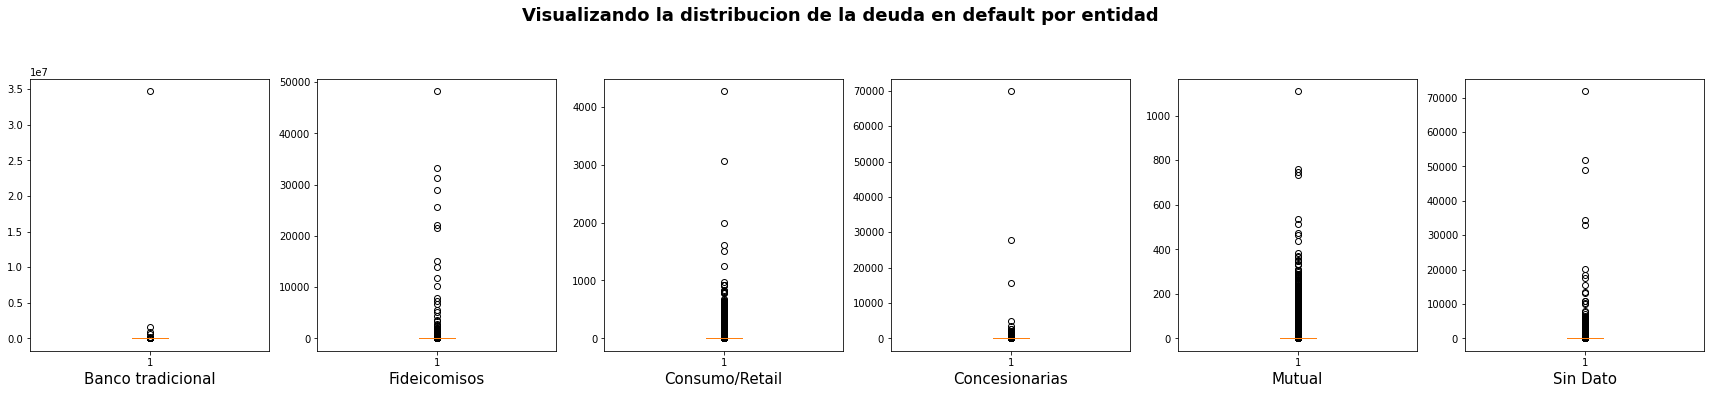

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30,5))       
fig.suptitle("Visualizando la distribucion de la deuda en default por entidad", fontsize = 18, fontweight = "bold", y = 1.08)
ax1.boxplot(df['E1_D'])  
ax2.boxplot(df['E2_D'])
ax3.boxplot(df['E3_D'])
ax4.boxplot(df['E4_D'])
ax5.boxplot(df['E5_D'])
ax6.boxplot(df['E6_D'])
ax1.set_xlabel('Banco tradicional', fontsize = 15)
ax2.set_xlabel('Fideicomisos', fontsize = 15)
ax3.set_xlabel('Consumo/Retail', fontsize = 15)
ax4.set_xlabel('Concesionarias', fontsize = 15)
ax5.set_xlabel('Mutual', fontsize = 15)
ax6.set_xlabel('Sin Dato', fontsize = 15)
plt.show()

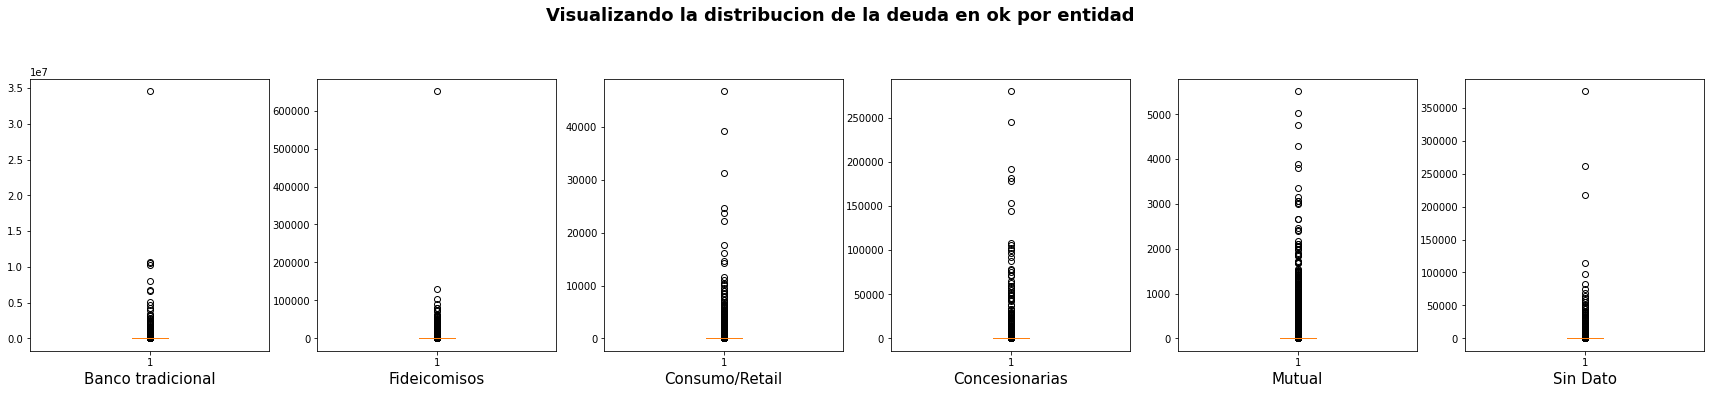

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30,5))       
fig.suptitle("Visualizando la distribucion de la deuda en ok por entidad", fontsize = 18, fontweight = "bold", y = 1.08)
ax1.boxplot(df['E1_Ok'])  
ax2.boxplot(df['E2_Ok'])
ax3.boxplot(df['E3_Ok'])
ax4.boxplot(df['E4_Ok'])
ax5.boxplot(df['E5_Ok'])
ax6.boxplot(df['E6_Ok'])
ax1.set_xlabel('Banco tradicional', fontsize = 15)
ax2.set_xlabel('Fideicomisos', fontsize = 15)
ax3.set_xlabel('Consumo/Retail', fontsize = 15)
ax4.set_xlabel('Concesionarias', fontsize = 15)
ax5.set_xlabel('Mutual', fontsize = 15)
ax6.set_xlabel('Sin Dato', fontsize = 15)
plt.show()

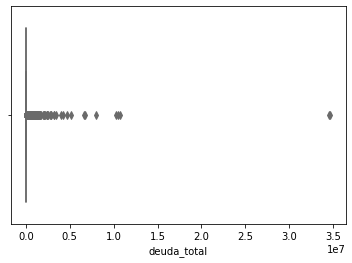

In [ ]:
# Graficamos la distribución de la deuda total
sns.boxplot(x='deuda_total' , data=df, palette="Set3")

In [ ]:
maximo_deuda_total = df['deuda_total'].max()

In [ ]:
df[['cuit','deuda_total']].sort_values(by = 'deuda_total', ascending= False).head()

,cuit,deuda_total
2961648,30500959629,34687819
2963272,30546689979,34552258
2964321,30588855631,10704946
2996507,33515950899,10494112
2962416,30522211563,10293426


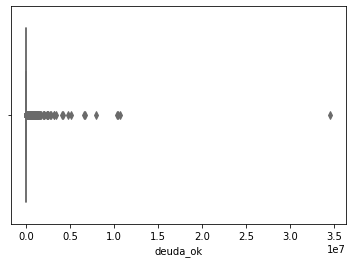

In [ ]:
# Graficamos la distribución de la deuda ok
sns.boxplot(x='deuda_ok' , data=df, palette="Set3")


In [ ]:
df[['cuit','deuda_ok']].sort_values(by = 'deuda_ok', ascending= False).head()

,cuit,deuda_ok
2963272,30546689979,34552258
2964321,30588855631,10704946
2996507,33515950899,10494112
2962416,30522211563,10293426
2961645,30500858628,7975899


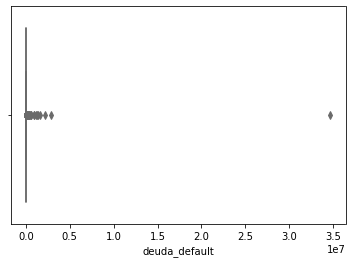

In [ ]:
# Graficamos la distribución de la deuda en default
sns.boxplot(x='deuda_default' , data=df, palette="Set3")


In [ ]:
df[['cuit','deuda_default']].sort_values(by = 'deuda_default', ascending= False).head()

,cuit,deuda_default
2961648,30500959629,34687819
2988214,30715228277,2814165
2965019,30611995128,2184864
2968374,30681491380,1659288
2996585,33537186009,1351774


Comparamos la cantidad de CUITs que se encuentran en situación de default vs aquellos CUITs que no se encuentran en mora.

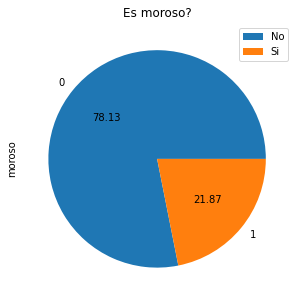

In [ ]:
df2 = df.copy()

# agregamos una marca simple de default 
df2['moroso'] = np.where(df['default'] >= 1 , 1,0)

#Gráfico de Torta 
#colores = ["#F4F1BB","#FFCAAF"]
plot = df2['moroso'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(5, 5),
                                            #colors=colores,
                                            title='Es moroso?')
plt.legend(['No', 'Si'])
# plt.show()

Realizamos un análisis similar al anterior, pero distinguiendo por la cantidad de deudas en default que posee cada persona observada.

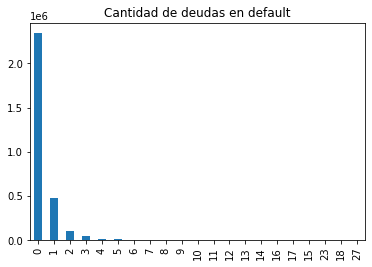

In [ ]:

plot = df['default'].value_counts().plot(kind='bar',
                                            title='Cantidad de deudas en default')

In [ ]:
cant_default = df[['cuit','default']].groupby(by='default').count()
cant_default['porcentaje'] = (cant_default['cuit'] / 3000000*100).round(2)

cant_default.sort_values(by='cuit', ascending=False)

,cuit,porcentaje
default,,
0,2343774,78.13
1,477618,15.92
2,105961,3.53
3,42551,1.42
4,17414,0.58
5,7238,0.24
6,2970,0.10
7,1339,0.04
8,592,0.02


La mayor cantidad de CUITs no poseen deudas en default (78% aprox). Un porcentaje menor (16% aprox) posee solo una deuda en default. El 3,53% posee dos deudas en default, y aproximadamente el 2,5% de los deudores restantes poseen 3 deudas o más en default.

<function matplotlib.pyplot.legend>

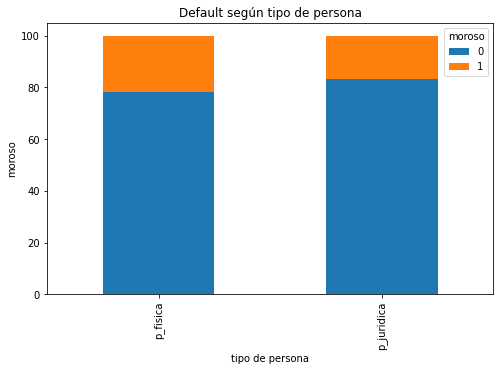

In [ ]:
#Gráfico de barras apiladas default según tipo de persona
df2['tipo_persona'] = np.where((df['empresa']==1), 'p_juridica','p_fisica')


pd.crosstab(index=df2['tipo_persona'],
            columns=df2['moroso']
                  ).apply(lambda r: r/r.sum()*100,
                          axis=1).plot(kind='bar', stacked=True,figsize=(8,5))
plt.title("Default según tipo de persona")
plt.xlabel("tipo de persona")
plt.ylabel("moroso")
plt.legend

In [ ]:
df2[['cuit','tipo_persona']].groupby('tipo_persona').count()

,cuit
tipo_persona,
p_fisica,2961591
p_juridica,38409


De los 3 millones de Cuits observados:
* 2.961.591 corresponden a personas físicas
* 38.409 corresponden a personas jurídicas

In [ ]:
df2['deuda_total'].sum()

937098603

In [ ]:
deuda_entidades = df2[['deuda_total','tipo_persona']].groupby('tipo_persona', as_index=False).sum()
deuda_entidades

,tipo_persona,deuda_total
0,p_fisica,513904058
1,p_juridica,423194545


In [ ]:
deuda_juridicas = deuda_entidades[deuda_entidades['tipo_persona' ]=='p_juridica']



In [ ]:
deuda_fisicas = deuda_entidades[deuda_entidades['tipo_persona' ]=='p_fisica']


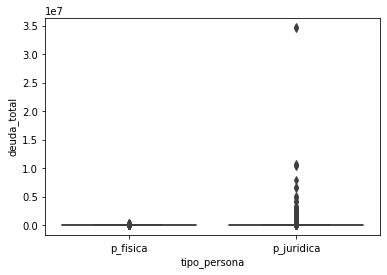

In [ ]:
# Distribucion de monto de credito por tipo de persona
sns.boxplot(x='tipo_persona', y='deuda_total', data=df2)

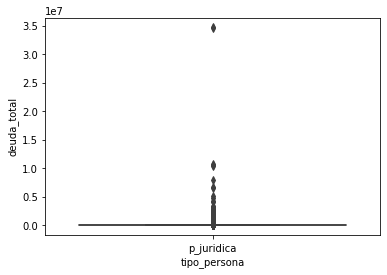

In [ ]:
df_juridicas = df2[df2['tipo_persona']=='p_juridica']

# Distribucion de monto de credito por tipo de persona
sns.boxplot(x='tipo_persona', y='deuda_total', data=df_juridicas)

Los importes de deuda tomada por personas físicas son significativamente inferiores a los tomados por personas jurídicas. Por otra parte, se notan algunos valores extremos en el caso de personas jurídicas.

In [ ]:
df2[['cuit', 'tipo_persona', 'deuda_total', 'deuda_ok', 'deuda_default']].sort_values(by='deuda_total', ascending = False).head(10)

,cuit,tipo_persona,deuda_total,deuda_ok,deuda_default
2961648,30500959629,p_juridica,34687819,0,34687819
2963272,30546689979,p_juridica,34552258,34552258,0
2964321,30588855631,p_juridica,10704946,10704946,0
2996507,33515950899,p_juridica,10494112,10494112,0
2962416,30522211563,p_juridica,10293426,10293426,0
2961645,30500858628,p_juridica,7975899,7975899,0
2982660,30712336532,p_juridica,6725638,6725638,0
2984826,30714322938,p_juridica,6582437,6582437,0
2970044,30700869918,p_juridica,5161045,5161045,0
2961976,30509529937,p_juridica,4724620,4724620,0


* 30500959629: Vicentin SAIC
* 30546689979: YPF S.A
* 30588855631: Sociedad Anonima La Sibila
* 33515950899: Visto Oil & Gas Argentina SAU
* 30522211563: First Data Conosur
* 30500858628: Molinos Rio de La Plata S.A
* 30712336532: Fideicomiso Financiero Nasa Serie II
* 30714322938: CNH INDUSTRIAL CAPITAL ARGENTINA S.A
* 30700869918: Bunge Argentina S.A
* 30509529937: GEAR S.A

Los 10 CUITs con mayores montos de deuda corresponden a grandes empresas industriales o empresas de inversión. Se destaca que de los 10 mayores deudores, solo uno de ellos (Vicentín SAIC) posee su deuda en default.

**Distribución de deuda por tipo de entidad**

In [ ]:
deuda_total = df2['deuda_total'].sum()

In [ ]:
df2['E1'] = df2['E1_D']+df2['E1_Ok']
df2['E2'] = df2['E2_D']+df2['E2_Ok']
df2['E3'] = df2['E3_D']+df2['E3_Ok']
df2['E4'] = df2['E4_D']+df2['E4_Ok']
df2['E5'] = df2['E5_D']+df2['E5_Ok']
df2['E6'] = df2['E6_D']+df2['E6_Ok']


df_entidades = df2[['tipo_persona','E1','E2','E3','E4','E5','E6']].groupby('tipo_persona', as_index=False).sum()


In [ ]:
df_entidades

,tipo_persona,E1,E2,E3,E4,E5,E6
0,p_fisica,427980474,15123992,48825033,6896986,1731771,13345802
1,p_juridica,406472925,5176068,1252608,5103701,22219,5167024


In [ ]:
fisica_entidades = df_entidades[df_entidades['tipo_persona'] == 'p_fisica']
fisica_entidades = fisica_entidades[['E1','E2','E3','E4','E5','E6']]
serie_1 = list(fisica_entidades.iloc[0])


In [ ]:
juridica_entidades = df_entidades[df_entidades['tipo_persona'] == 'p_juridica']
juridica_entidades = juridica_entidades[['E1','E2','E3','E4','E5','E6']]
serie_2 = list(juridica_entidades.iloc[0])

In [ ]:
print(serie_1)
print(serie_2)

[427980474, 15123992, 48825033, 6896986, 1731771, 13345802]
[406472925, 5176068, 1252608, 5103701, 22219, 5167024]


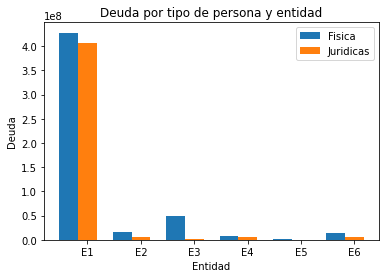

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

numero_de_grupos = len(serie_1)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.35
 
plt.bar(indice_barras, serie_1, width=ancho_barras, label='Fisica')
plt.bar(indice_barras + ancho_barras, serie_2, width=ancho_barras, label='Juridicas')
plt.legend(loc='best')
## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ('E1','E2','E3','E4','E5','E6'))
 
plt.ylabel('Deuda')
plt.xlabel('Entidad')
plt.title('Deuda por tipo de persona y entidad')
 
plt.show()

Tanto personas físicas como jurídicas poseen una mayor proporción de deuda con la entidad 1.

In [ ]:
entidades_proporc = df_entidades.copy()
entidades_proporc['total_deuda'] = df_entidades['E1']+df_entidades['E2']+df_entidades['E3']+df_entidades['E4']+df_entidades['E5']+df_entidades['E6']
entidades_proporc['E1_%'] = (df_entidades['E1']/entidades_proporc['total_deuda'])*100
entidades_proporc['E2_%'] = (df_entidades['E2']/entidades_proporc['total_deuda'])*100
entidades_proporc['E3_%'] = (df_entidades['E3']/entidades_proporc['total_deuda'])*100
entidades_proporc['E4_%'] = (df_entidades['E4']/entidades_proporc['total_deuda'])*100
entidades_proporc['E5_%'] = (df_entidades['E5']/entidades_proporc['total_deuda'])*100
entidades_proporc['E6_%'] = (df_entidades['E6']/entidades_proporc['total_deuda'])*100

entidades_proporc[['tipo_persona','E1_%','E2_%','E3_%','E4_%','E5_%','E6_%']]
            

,tipo_persona,E1_%,E2_%,E3_%,E4_%,E5_%,E6_%
0,p_fisica,83.280229,2.942960,9.500807,1.342077,0.336983,2.596944
1,p_juridica,96.048716,1.223094,0.295989,1.205994,0.005250,1.220957


In [ ]:
entidades_proporc

,tipo_persona,E1,E2,E3,E4,E5,E6,total_deuda,E1_%,E2_%,E3_%,E4_%,E5_%,E6_%
0,p_fisica,427980474,15123992,48825033,6896986,1731771,13345802,513904058,83.280229,2.942960,9.500807,1.342077,0.336983,2.596944
1,p_juridica,406472925,5176068,1252608,5103701,22219,5167024,423194545,96.048716,1.223094,0.295989,1.205994,0.005250,1.220957


**Comparamos ahora los niveles de deuda de hombres y mujeres**

In [ ]:
df_fisica = df2[df2['tipo_persona']=='p_fisica']

df_fisica = df_fisica[['cuit','default','deuda_total','deuda_default','deuda_ok','mujer','empresa','hombre', 'E1','E2','E3','E4','E5','E6']]

df_fisica

,cuit,default,deuda_total,deuda_default,deuda_ok,mujer,empresa,hombre,E1,E2,E3,E4,E5,E6
0,20000079643,1,16,16,0,0,0,1,0,0,0,0,0,16
1,20000110680,0,3,0,3,0,0,1,3,0,0,0,0,0
2,20000143368,0,11,0,11,0,0,1,11,0,0,0,0,0
3,20000297713,0,67,0,67,0,0,1,0,0,67,0,0,0
4,20000788261,0,9,0,9,0,0,1,0,0,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961586,27999014327,0,8,0,8,1,0,0,8,0,0,0,0,0
2961587,27999015471,0,149,0,149,1,0,0,149,0,0,0,0,0
2961588,27999019825,0,118,0,118,1,0,0,118,0,0,0,0,0
2961589,27999019965,0,50,0,50,1,0,0,50,0,0,0,0,0


In [ ]:
df_fisica['otros'] = np.where((df_fisica['mujer']==0) & ((df_fisica['hombre']==0) & (df_fisica['empresa']==0)), 1,0)

df_fisica[df_fisica['otros'] == 1].count()

cuit             16717
default          16717
deuda_total      16717
deuda_default    16717
deuda_ok         16717
mujer            16717
empresa          16717
hombre           16717
E1               16717
E2               16717
E3               16717
E4               16717
E5               16717
E6               16717
otros            16717
dtype: int64

Existen 16717 CUITs que no podemos clasificar entre masculinos y femeninos a partir de la conformación de sus CUITs. 

In [ ]:
df_otros = df_fisica[df_fisica['otros'] == 1]
df_otros.shape



(16717, 15)

In [ ]:
df_otros['genero'] = 'Otro'

df_otros

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cuit,default,deuda_total,deuda_default,deuda_ok,mujer,empresa,hombre,E1,E2,E3,E4,E5,E6,otros,genero
1361489,23006665543,0,15,0,15,0,0,0,15,0,0,0,0,0,1,Otro
1361937,23016840777,0,5,0,5,0,0,0,5,0,0,0,0,0,1,Otro
1361952,23017174843,0,10,0,10,0,0,0,10,0,0,0,0,0,1,Otro
1362390,23023845113,0,20,0,20,0,0,0,20,0,0,0,0,0,1,Otro
1362877,23029285233,0,8,0,8,0,0,0,8,0,0,0,0,0,1,Otro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646362,24956023005,0,19,0,19,0,0,0,18,0,1,0,0,0,1,Otro
1646363,24958583644,0,153,0,153,0,0,0,153,0,0,0,0,0,1,Otro
1646364,24958939805,0,9,0,9,0,0,0,0,0,9,0,0,0,1,Otro
1646365,24959088736,0,117,0,117,0,0,0,117,0,0,0,0,0,1,Otro


In [ ]:
df_fisica = df_fisica[df_fisica['otros'] == 0]
df_fisica.shape

(2944874, 15)

In [ ]:
df_fisica['genero'] = np.where((df_fisica['hombre']==1) & ((df_fisica['mujer']== 0)), 'Hombre', 'Mujer')
df_fisica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cuit,default,deuda_total,deuda_default,deuda_ok,mujer,empresa,hombre,E1,E2,E3,E4,E5,E6,otros,genero
0,20000079643,1,16,16,0,0,0,1,0,0,0,0,0,16,0,Hombre
1,20000110680,0,3,0,3,0,0,1,3,0,0,0,0,0,0,Hombre
2,20000143368,0,11,0,11,0,0,1,11,0,0,0,0,0,0,Hombre
3,20000297713,0,67,0,67,0,0,1,0,0,67,0,0,0,0,Hombre
4,20000788261,0,9,0,9,0,0,1,0,0,9,0,0,0,0,Hombre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961586,27999014327,0,8,0,8,1,0,0,8,0,0,0,0,0,0,Mujer
2961587,27999015471,0,149,0,149,1,0,0,149,0,0,0,0,0,0,Mujer
2961588,27999019825,0,118,0,118,1,0,0,118,0,0,0,0,0,0,Mujer
2961589,27999019965,0,50,0,50,1,0,0,50,0,0,0,0,0,0,Mujer


In [ ]:
df_fisica2 = pd.concat([df_otros, df_fisica], axis=0)

In [ ]:
df_fisica2

,cuit,default,deuda_total,deuda_default,deuda_ok,mujer,empresa,hombre,E1,E2,E3,E4,E5,E6,otros,genero
1361489,23006665543,0,15,0,15,0,0,0,15,0,0,0,0,0,1,Otro
1361937,23016840777,0,5,0,5,0,0,0,5,0,0,0,0,0,1,Otro
1361952,23017174843,0,10,0,10,0,0,0,10,0,0,0,0,0,1,Otro
1362390,23023845113,0,20,0,20,0,0,0,20,0,0,0,0,0,1,Otro
1362877,23029285233,0,8,0,8,0,0,0,8,0,0,0,0,0,1,Otro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961586,27999014327,0,8,0,8,1,0,0,8,0,0,0,0,0,0,Mujer
2961587,27999015471,0,149,0,149,1,0,0,149,0,0,0,0,0,0,Mujer
2961588,27999019825,0,118,0,118,1,0,0,118,0,0,0,0,0,0,Mujer
2961589,27999019965,0,50,0,50,1,0,0,50,0,0,0,0,0,0,Mujer


In [ ]:
df_fisica2['moroso'] = np.where(df_fisica2['default'] >= 1 , 1,0)

In [ ]:
df_fisica2[['cuit','genero','deuda_total']].groupby('genero').count()

,cuit,deuda_total
genero,,
Hombre,1497762,1497762
Mujer,1447112,1447112
Otro,16717,16717


In [ ]:
df_fisica2

,cuit,default,deuda_total,deuda_default,deuda_ok,mujer,empresa,hombre,E1,E2,E3,E4,E5,E6,otros,genero,moroso
1361489,23006665543,0,15,0,15,0,0,0,15,0,0,0,0,0,1,Otro,0
1361937,23016840777,0,5,0,5,0,0,0,5,0,0,0,0,0,1,Otro,0
1361952,23017174843,0,10,0,10,0,0,0,10,0,0,0,0,0,1,Otro,0
1362390,23023845113,0,20,0,20,0,0,0,20,0,0,0,0,0,1,Otro,0
1362877,23029285233,0,8,0,8,0,0,0,8,0,0,0,0,0,1,Otro,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961586,27999014327,0,8,0,8,1,0,0,8,0,0,0,0,0,0,Mujer,0
2961587,27999015471,0,149,0,149,1,0,0,149,0,0,0,0,0,0,Mujer,0
2961588,27999019825,0,118,0,118,1,0,0,118,0,0,0,0,0,0,Mujer,0
2961589,27999019965,0,50,0,50,1,0,0,50,0,0,0,0,0,0,Mujer,0


<function matplotlib.pyplot.legend>

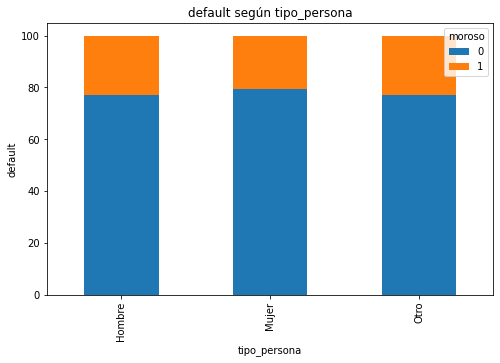

In [ ]:
pd.crosstab(index=df_fisica2['genero'],
            #index=df_G,
            columns=df_fisica2['moroso']
                  ).apply(lambda r: r/r.sum()*100,
                          axis=1).plot(kind='bar', stacked=True,figsize=(8,5))
plt.title("default según tipo_persona")
plt.xlabel("tipo_persona")
plt.ylabel("default")
plt.legend

No se notan diferencias en el nivel de morosidad de las personas físicas según su genero. Tanto hombres, mujeres y aquellos sin genero definido poseen una proporción similar de morosos (alrededor de un 80%).

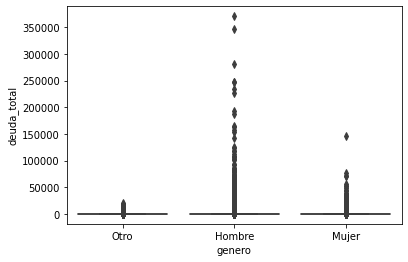

In [ ]:
# Distribucion de monto de credito por tipo de persona
sns.boxplot(x='genero', y='deuda_total', data=df_fisica2)

Podemos observar que las deudas del género masculino tienen mayor dispersión que las deudas de las mujeres, siendo además montos más elevados. También podemos observar que tienen ligeramente más deuda en default.